In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Input
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Periksa ketersediaan GPU
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available:  True
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set random seed untuk reproduksibilitas
tf.random.set_seed(42)
np.random.seed(42)

# PERSIAPAN DATA

In [6]:
# Buat DataFrame
df = pd.read_csv("ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()
print(f"Jumlah data: {len(df)}")

Jumlah data: 22641


In [7]:
# Tokenisasi text
max_features = 10000  # Jumlah kata terbanyak yang akan digunakan
max_len = 200  # Panjang maksimum sequence

tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Review Text'])
X = tokenizer.texts_to_sequences(df['Review Text'])
X = pad_sequences(X, maxlen=max_len, padding='post')
y = df['Recommended IND'].values

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

Jumlah data training: 18112
Jumlah data testing: 4529


# FUNGSI UNTUK MEMBUAT MODEL

In [9]:
def create_rnn_model():
    """Membuat model RNN untuk klasifikasi sentimen"""
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
        Bidirectional(SimpleRNN(128, return_sequences=False)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [10]:
def create_lstm_model():
    """Membuat model LSTM untuk klasifikasi sentimen"""
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [11]:
def create_gru_model():
    """Membuat model GRU untuk klasifikasi sentimen"""
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
        Bidirectional(GRU(128, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# FUNGSI EVALUASI

In [12]:
def evaluate_model(model, X_test, y_test):
    """Evaluasi model dengan berbagai metrik"""
    # Prediksi probabilitas
    y_prob = model.predict(X_test, verbose=0)
    # Prediksi kelas (0 atau 1)
    y_pred = (y_prob >= 0.5).astype(int)

    # Hitung metrik
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f1_squared = f1 ** 2

    # Hitung AUC-ROC hanya jika kedua kelas hadir
    auc = 0
    if len(np.unique(y_test)) > 1:
        auc = roc_auc_score(y_test, y_prob)

    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_squared': f1_squared,
        'auc': auc,
        'y_true': y_test,
        'y_prob': y_prob.flatten()
    }

    return metrics_dict

# FUNGSI VISUALISASI


In [13]:
def plot_training_history(history, model_name):
    """Plot grafik akurasi dan loss selama training"""
    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Akurasi Model {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Model {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
def plot_roc_curve(y_true, y_prob, model_name):
    """Plot kurva ROC"""
    if len(np.unique(y_true)) > 1:  # Pastikan ada kedua kelas
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.fill_between(fpr, tpr, alpha=0.3)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        print("Tidak dapat membuat ROC curve karena hanya ada satu kelas dalam data pengujian.")

# TRAIN & EVALUATE MODEL

In [15]:
def train_and_evaluate(create_model_fn, model_name, epochs=10):
    """Fungsi untuk melatih dan mengevaluasi model"""
    # Inisialisasi model
    model = create_model_fn()
    print(f"\nArsitektur Model {model_name}:")
    model.summary()

    # Callbacks untuk training
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}_best_model.h5', save_best_only=True, monitor='val_loss')
    ]

    # Training model
    print(f"\nMelatih model {model_name}...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluasi model
    metrics = evaluate_model(model, X_test, y_test)

    # Print hasil
    print(f"\n===== Hasil Evaluasi Model {model_name} =====")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Squared: {metrics['f1_squared']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Visualisasi hasil
    plot_training_history(history, model_name)
    plot_roc_curve(metrics['y_true'], metrics['y_prob'], model_name)

    return model, history, metrics

# EKSEKUSI PELATIHAN MODEL

In [16]:
num_epochs = 10


Pelatihan Model RNN


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Arsitektur Model RNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Melatih model RNN...
Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8078 - loss: 0.4973

453/453 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.8078 - loss: 0.4972 - val_accuracy: 0.8076 - val_loss: 0.4892
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8201 - loss: 0.4835

453/453 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.8201 - loss: 0.4835 - val_accuracy: 0.8093 - val_loss: 0.4840
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8188 - loss: 0.4696

453/453 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8188 - loss: 0.4696 - val_accuracy: 0.8073 - val_loss: 0.4663
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8194 - loss: 0.4356

453/453 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8194 - loss: 0.4356 - val_accuracy: 0.8015 - val_loss: 0.4247
Epoch 5/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8182 - loss: 0.4289 - val_accuracy: 0.7982 - val_loss: 0.4417
Epoch 6/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8306 - loss: 0.3888 - val_accuracy: 0.8220 - val_loss: 0.4417
Epoch 7/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.8199 - loss: 0.4472 - val_accuracy: 0.8049 - val_loss: 0.4806

===== Hasil Evaluasi Model RNN =====
Accuracy: 0.8161
Precision: 0.8634
Recall: 0.9217
F1 Squared: 0.7950
AUC: 0.7766


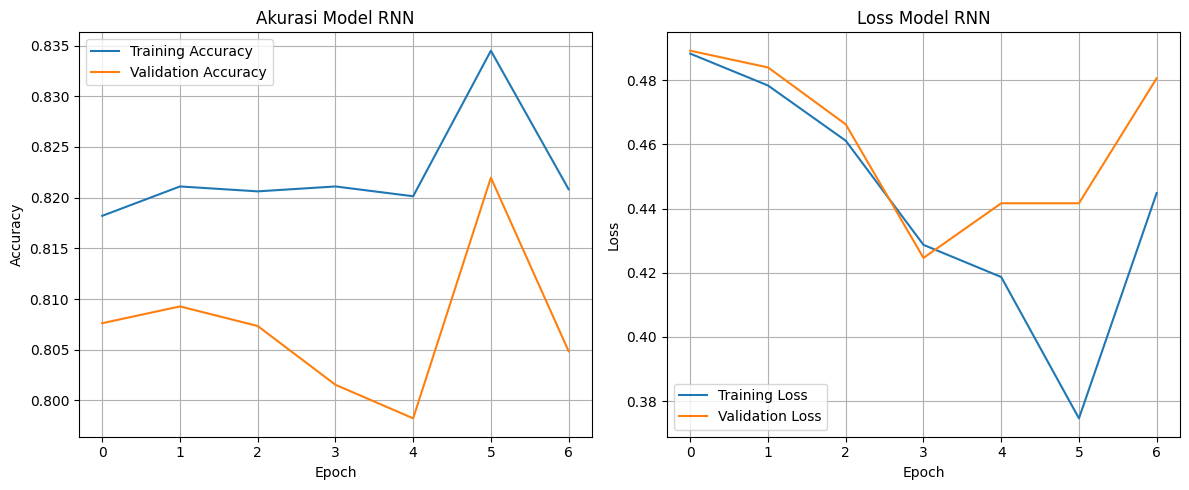

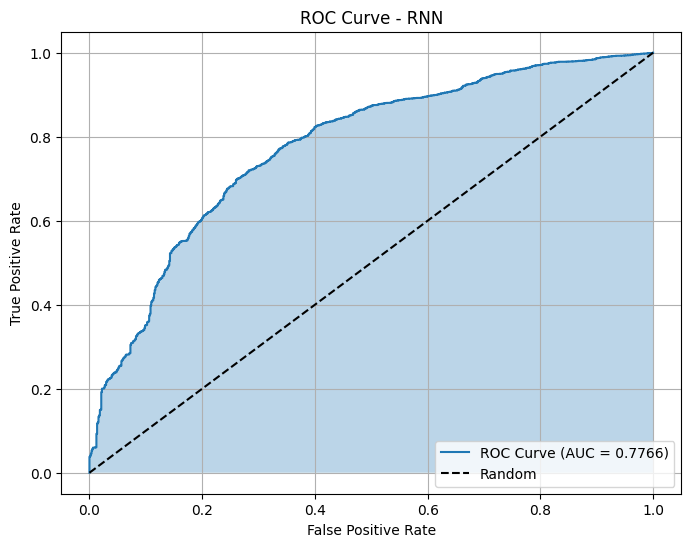

In [17]:
# RNN
print("\n" + "="*50)
print("Pelatihan Model RNN")
print("="*50)
rnn_model, rnn_history, rnn_metrics = train_and_evaluate(create_rnn_model, "RNN", epochs=num_epochs)


Pelatihan Model LSTM

Arsitektur Model LSTM:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Melatih model LSTM...
Epoch 1/10
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8285 - loss: 0.4240

453/453 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.8286 - loss: 0.4237 - val_accuracy: 0.8667 - val_loss: 0.3386
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8887 - loss: 0.2551 - val_accuracy: 0.8794 - val_loss: 0.3435
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9172 - loss: 0.2104 - val_accuracy: 0.8805 - val_loss: 0.3803
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9341 - loss: 0.1775 - val_accuracy: 0.8620 - val_loss: 0.4409

===== Hasil Evaluasi Model LSTM =====
Accuracy: 0.8737
Precision: 0.8888
Recall: 0.9672
F1 Squared: 0.8580
AUC: 0.9134


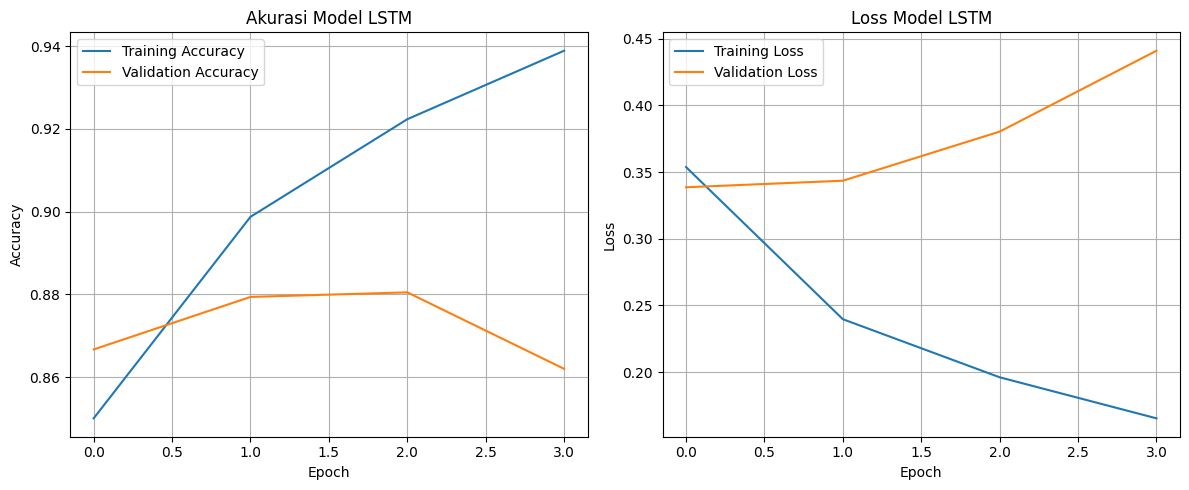

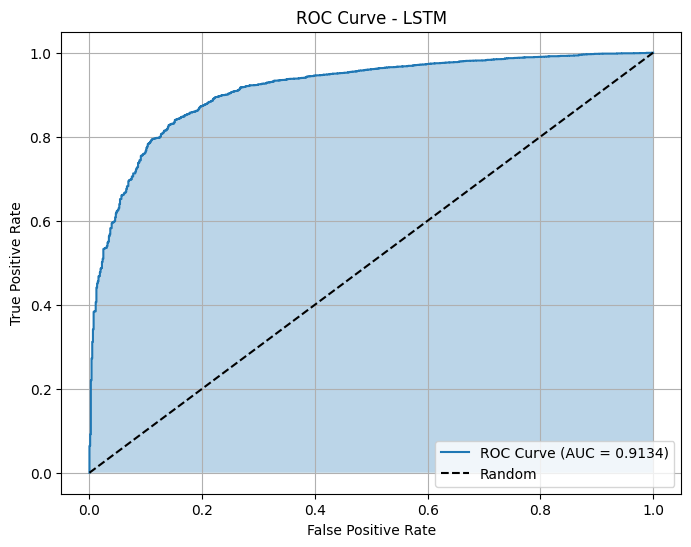

In [18]:
# LSTM
print("\n" + "="*50)
print("Pelatihan Model LSTM")
print("="*50)
lstm_model, lstm_history, lstm_metrics = train_and_evaluate(create_lstm_model, "LSTM", epochs=num_epochs)


Pelatihan Model GRU

Arsitektur Model GRU:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Melatih model GRU...
Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8225 - loss: 0.4479

453/453 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8226 - loss: 0.4478 - val_accuracy: 0.8540 - val_loss: 0.3094
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8790 - loss: 0.2730

453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8790 - loss: 0.2730 - val_accuracy: 0.8860 - val_loss: 0.2814
Epoch 3/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9155 - loss: 0.2060 - val_accuracy: 0.8879 - val_loss: 0.3385
Epoch 4/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9373 - loss: 0.1651 - val_accuracy: 0.8844 - val_loss: 0.3187
Epoch 5/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9493 - loss: 0.1320 - val_accuracy: 0.8838 - val_loss: 0.4196

===== Hasil Evaluasi Model GRU =====
Accuracy: 0.8914
Precision: 0.9378
Recall: 0.9292
F1 Squared: 0.8714
AUC: 0.9309


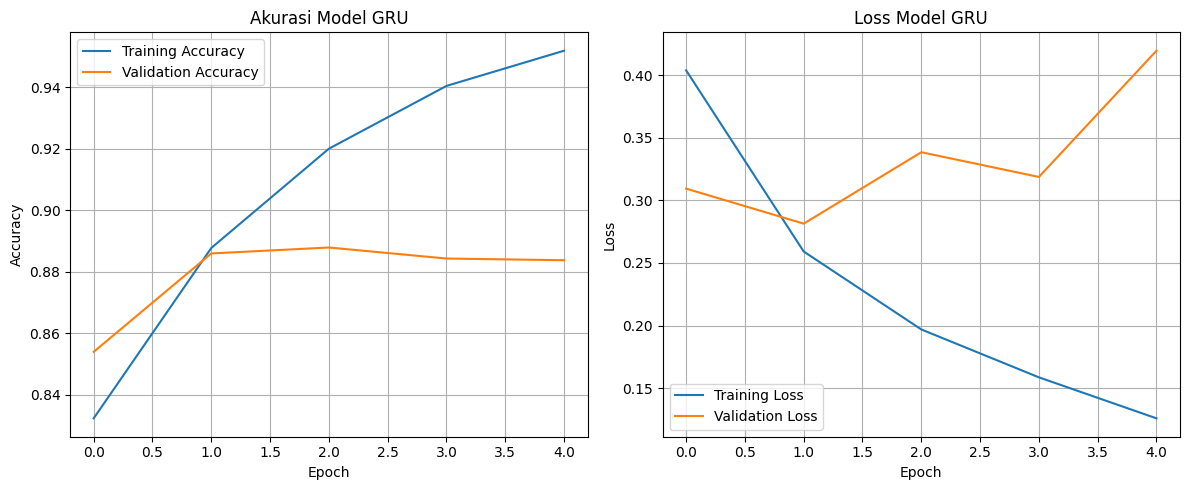

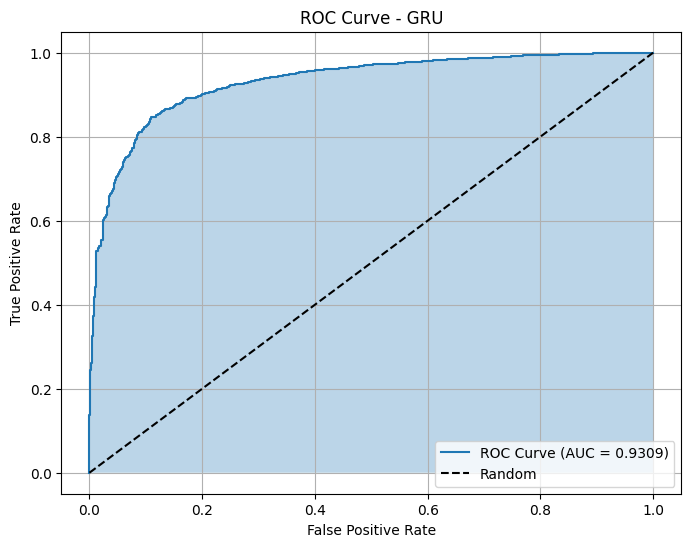

In [19]:
# GRU
print("\n" + "="*50)
print("Pelatihan Model GRU")
print("="*50)
gru_model, gru_history, gru_metrics = train_and_evaluate(create_gru_model, "GRU", epochs=num_epochs)

# PERBANDINGAN MODEL

In [20]:
models = ["RNN", "LSTM", "GRU"]
metrics = [rnn_metrics, lstm_metrics, gru_metrics]

print("\n" + "="*50)
print("Perbandingan Model")
print("="*50)

comparison_data = {
    'Model': models,
    'Accuracy': [m['accuracy'] for m in metrics],
    'Precision': [m['precision'] for m in metrics],
    'Recall': [m['recall'] for m in metrics],
    'F1 Squared': [m['f1_squared'] for m in metrics],
    'AUC': [m['auc'] for m in metrics]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)


Perbandingan Model
  Model  Accuracy  Precision    Recall  F1 Squared       AUC
0   RNN  0.816074   0.863407  0.921711    0.794963  0.776575
1  LSTM  0.873703   0.888752  0.967178    0.858046  0.913417
2   GRU  0.891367   0.937822  0.929244    0.871447  0.930914


In [21]:
# Visualisasi perbandingan model dengan barplot
plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

In [22]:
# Buat data untuk plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Squared', 'AUC']
x = np.arange(len(models))
width = 0.15
multiplier = 0

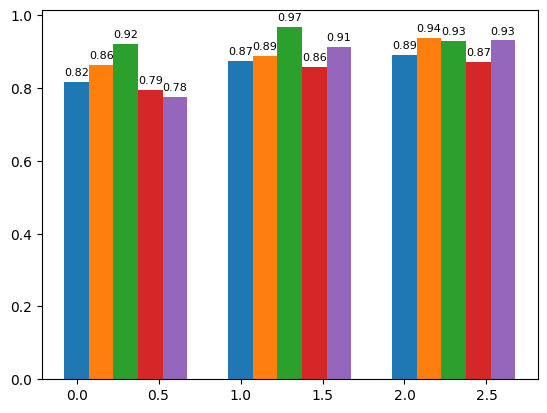

In [23]:
# Plot bars untuk setiap metrik
for metric in metrics_to_plot:
    offset = width * multiplier
    bars = plt.bar(x + offset, comparison_df[metric], width, label=metric)

    # Tambahkan label nilai pada setiap bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

    multiplier += 1

<ipython-input-24-81b7d84a3689>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


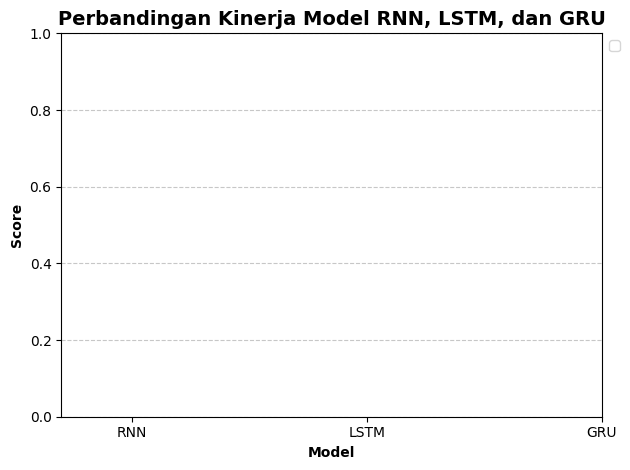

In [24]:
# Konfigurasi plot
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Perbandingan Kinerja Model RNN, LSTM, dan GRU', fontsize=14, fontweight='bold')
plt.xticks(x + width * 2, models)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

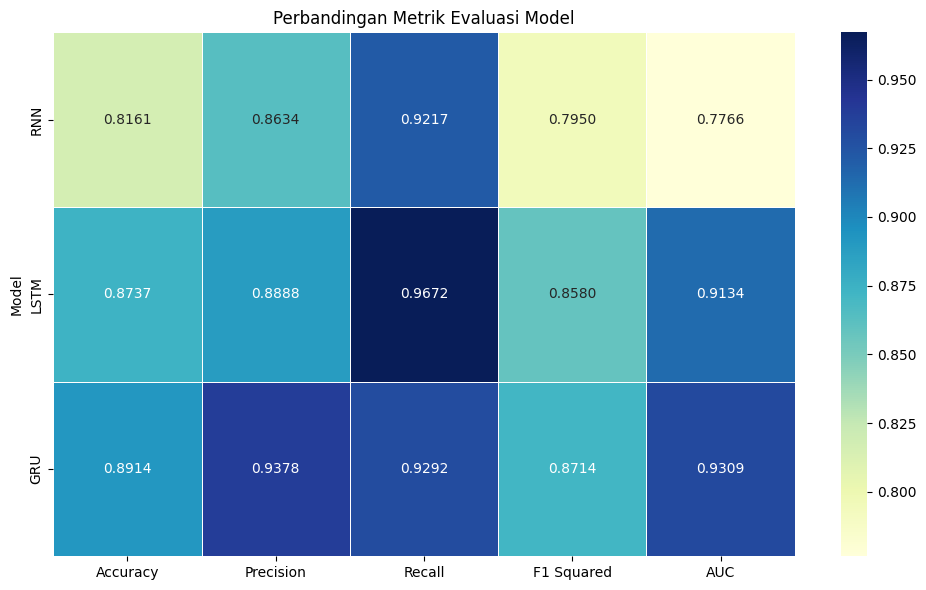

In [25]:
# Visualisasi heatmap perbandingan model
plt.figure(figsize=(10, 6))
heatmap_data = comparison_df.set_index('Model')[metrics_to_plot]
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5)
plt.title('Perbandingan Metrik Evaluasi Model')
plt.tight_layout()
plt.show()

# CONTOH PREDIKSI

In [26]:
def predict_sentiment(model, text, tokenizer, max_len):
    """Fungsi untuk memprediksi sentimen dari teks baru"""
    # Tokenisasi text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Prediksi
    prediction = model.predict(padded_sequences, verbose=0)[0][0]
    sentiment = "Positif (Recommended)" if prediction >= 0.5 else "Negatif (Not Recommended)"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    return {
        'text': text,
        'probability': float(prediction),
        'sentiment': sentiment,
        'confidence': float(confidence)
    }

In [27]:
# Contoh teks untuk diprediksi
sample_texts = [
    "The dress is beautiful and fits perfectly. I love it!",
    "This shirt is horrible quality and ripped after one wash.",
    "Average quality, not great but not bad either."
]

print("\n" + "="*50)
print("Contoh Prediksi dengan Model GRU")
print("="*50)

for text in sample_texts:
    result = predict_sentiment(gru_model, text, tokenizer, max_len)
    print(f"\nText: {result['text']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probability: {result['probability']:.4f}")


Contoh Prediksi dengan Model GRU

Text: The dress is beautiful and fits perfectly. I love it!
Sentiment: Positif (Recommended)
Confidence: 0.9803
Probability: 0.9803

Text: This shirt is horrible quality and ripped after one wash.
Sentiment: Negatif (Not Recommended)
Confidence: 0.7755
Probability: 0.2245

Text: Average quality, not great but not bad either.
Sentiment: Negatif (Not Recommended)
Confidence: 0.7843
Probability: 0.2157
